Разработка материалов для тренировки технологии INDAGO.
В папки проблема 1,  проблема 2,  проблема 3 добавлены 5 фотографий в “test” и 20 фотографий в  “train” (согласно ТЗ), были обучены и протестирования следующие модели: простая сверточная нейронная сеть, предобученные модели MobileNetV2, ResNet50, Xception и гибридная архитектура (MobileNetV2 как базовая модель + сверточные слои)
Лучшие показатели оказались у модели Xception+сверточные слои


In [1]:
import os
import numpy as np
import cv2
import shutil
from tensorflow.keras.models import Model, Sequential  
from tensorflow.keras.applications import Xception  
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, Attention

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import euclidean_distances

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [2]:
# создаем дерево папок по ТЗ
base_dir = 'Область носа 7'
problems = {
    'Проблема 1': ['greasy', 'clean'],
    'Проблема 2': ['pigmentation', 'clean'],
    'Проблема 3': ['black dots', 'clean']
}

for problem, classes in problems.items():
    problem_path = os.path.join(base_dir, problem)
    
    os.makedirs(os.path.join(problem_path, 'test'), exist_ok=True)
    os.makedirs(os.path.join(problem_path, 'train'), exist_ok=True)
    
    for class_name in classes:
        os.makedirs(os.path.join(problem_path, 'test', class_name), exist_ok=True)
        os.makedirs(os.path.join(problem_path, 'train', class_name), exist_ok=True)

print("Структура папок  создана")

Структура папок  создана


Тестирование различных моделей


In [48]:
# CNN
# model = Sequential([
#     layers.Conv2D(32, (3, 3), activation='relu', input_shape=(250, 250, 3)),
#     layers.MaxPooling2D(pool_size=(2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D(pool_size=(2, 2)),
#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.MaxPooling2D(pool_size=(2, 2)),
#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.MaxPooling2D(pool_size=(2, 2)),
#     layers.Flatten(),
#     layers.Dense(256, activation='relu'),
#     layers.Dropout(0.5),  
#     layers.Dense(4, activation='softmax') # 4 класса
# ])

In [33]:
# загрузка предобученной модели MobileNetV2
# base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(250, 250, 3))

# # Добавление полносвязных слоев для классификации
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)
# predictions = Dense(4, activation='softmax')(x)  # Изменен последний слой

# model = Model(inputs=base_model.input, outputs=predictions)

In [71]:
# base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(250, 250, 3))
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)
# predictions = Dense(num_classes, activation='softmax')(x)

# создание модели
# model = Model(inputs=base_model.input, outputs=predictions)  


In [120]:
# #загрузка MobileNetV2 без верхнего слоя
# base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(250, 250, 3))

# #замораживание слоев базовой модели
# base_model.trainable = False

# # создание модели
# inputs = layers.Input(shape=(250, 250, 3))

# x = base_model(inputs)
# x = layers.GlobalAveragePooling2D()(x)

# # добавление дополнительных слоев
# x = layers.Dense(250, activation='relu')(x)  # Полносвязный слой
# x = layers.Dropout(0.5)(x)  # Слой Dropout для предотвращения переобучения
# outputs = layers.Dense(4, activation='softmax')(x)  # Выходной слой

# model = Model(inputs, outputs)


In [3]:
class_names = ['greasy', 'pigmentation', 'black dots', 'clean']
# загрузка предобученной модели Xception
base_model = Xception(weights='imagenet', include_top=False, input_shape=(250, 250, 3))

# добавление полносвязных слоев для классификации
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Добавление слоя Dropout с вероятностью 0.5
x = Dense(512, activation='relu')(x)  # Добавление нового слоя Dense
x = Dropout(0.5)(x)
# Определяем количество классов
num_classes = len(class_names)

# Добавляем последний слой для классификации, используя num_classes
predictions = Dense(num_classes, activation='softmax')(x)

# создание модели
model = Model(inputs=base_model.input, outputs=predictions)


In [4]:
# компилируем модель
model.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [5]:
# # смотрим слои модели
# for layer in model.layers:
#     print(layer.name)
# # имя предпоследнего солоя надо указывать в промежуточной модели!!! для получения Эмбеддингов 
# # intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('dense_21').output)

In [26]:
# структура модели 
#model.summary()

In [6]:
# функция train_generator test_generator
def create_generators(base_dir, problems):
    generators = {}
    class_mapping = {}
    next_index = 0

    for problem, classes in problems.items():
        problem_path = os.path.join(base_dir, problem)

        for class_name in classes:
            if class_name not in class_mapping:
                class_mapping[class_name] = next_index
                next_index += 1

        # Data Augmentation
        # Аугментация данных создает различные преобразования исходных изображений, добавляя разнообразие в обучающую выборку 
            train_datagen = ImageDataGenerator(
            rotation_range=40,      # угол (в градусах) для случайного поворота изображения (Вращение изображения)
            width_shift_range=0.2,  # Сдвиг по ширине (изображение сдвинуто по ширине на 20% от общей ширины)
            height_shift_range=0.2, # Сдвиг по высоте (cдвиг на 20% от общей высоты... )
            shear_range=0.2,        # угол сдвига (shear) в градусах
            zoom_range=0.2,         # увеличивать или уменьшать размер изображения до 20%
            horizontal_flip=True,   # параметр включает горизонтальное отражение изображений
            fill_mode='nearest',     # 'nearest' для заполнения "пустых" пикселей будут использоваться значения ближайших пикселей 
            #brightness_range=[0.8, 1.2],  # Изменение яркости
            channel_shift_range=20.0  # Сдвиг по каналам
        )

        train_generator = train_datagen.flow_from_directory(
            os.path.join(problem_path, 'train'),
            target_size=(250, 250),
            batch_size=32,
            class_mode='sparse',
            classes=classes,
            shuffle=True # данные перемешиваем для более эффективношго и устойчивого обучение модели
        )

        test_datagen = ImageDataGenerator(rescale=1.0 / 255.0) # test_generator надо без Аугментации данных
        test_generator = test_datagen.flow_from_directory(
            os.path.join(problem_path, 'test'),
            target_size=(250, 250),
            batch_size=32,
            class_mode='sparse',
            classes=classes,
            shuffle=False # данные не перемешиваем!
        )

        # cохраняем генераторы и маппинг классов для каждой проблемы
        generators[problem] = {
            'train': {
                'generator': train_generator,
                'class_indices': {class_name: class_mapping[class_name] for class_name in classes}
            },
            'test': {
                'generator': test_generator,
                'class_indices': {class_name: class_mapping[class_name] for class_name in classes}
            },
            'num_classes': len(classes)  # Добавляем количество классов
        }
   
    print("Генераторы созданы")
    
    # выводим индексы классов для каждой проблемы
    for problem, data in generators.items():
        print(f"Проблема {problem} class indices: {data['train']['class_indices']}")

    return generators, class_mapping

In [7]:
# смотрим классы по проблемам
problems = {
    'Проблема 1': ['clean', 'greasy'],
    'Проблема 2': ['clean', 'pigmentation'],
    'Проблема 3': ['black dots', 'clean']
}

# cоздаем генераторы и отображение классов
generators, class_mapping = create_generators(base_dir, problems)
print("Генераторы созданы для каждой проблемы")

# полученные индексы классов
for problem, mapping in class_mapping.items():
    print(f"{problem} class indices: {mapping}")

Found 25 images belonging to 2 classes.
Found 14 images belonging to 2 classes.
Found 26 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
Found 25 images belonging to 2 classes.
Found 11 images belonging to 2 classes.
Генераторы созданы
Проблема Проблема 1 class indices: {'clean': 0, 'greasy': 1}
Проблема Проблема 2 class indices: {'clean': 0, 'pigmentation': 2}
Проблема Проблема 3 class indices: {'black dots': 3, 'clean': 0}
Генераторы созданы для каждой проблемы
clean class indices: 0
greasy class indices: 1
pigmentation class indices: 2
black dots class indices: 3


In [8]:
# train_generator для Проблемы 1
train_generator = generators['Проблема 1']['train']['generator']

# проверка размерности
X, y = next(train_generator)
print(X.shape, y.shape)

(25, 250, 250, 3) (25,)


In [9]:
# test_generator для Проблемы 1
test_generator = generators['Проблема 1']['test']['generator']

# проверка размерности
X, y = next(test_generator)
print(X.shape, y.shape)  

(14, 250, 250, 3) (14,)


In [38]:
# надо обучить модель на тренировочных данных, а затем оценить ее эффективность на валидационных (тестовых) данных

In [10]:
epochs = 10  # количество эпох 
batch_size = 32
histories = {}  # для истории обучения 

# обучение модели 
for problem, data in generators.items():
    print(f"Начинаем обучение для {problem}...")
    
    # генераторы для обучения и тестирования
    train_gen = data['train']['generator']  # Получаем train генератор
    test_gen = data['test']['generator']    # Получаем test генератор

    # определяем количество шагов за эпоху
    steps_per_epoch = train_gen.samples // batch_size
    validation_steps = test_gen.samples // batch_size

    #try:
        
    history = model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=test_gen,
        validation_steps=validation_steps
    )
    # cохраняем историю обучения
    histories[problem] = history.history  
    
    print(f"Обучение завершено для {problem}.")
    # except Exception as e:
    #     print(f"Ошибка во время обучения для {problem}: {e}")

Начинаем обучение для Проблема 1...
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 29s 29s/step - accuracy: 0.2000 - loss: 1.6069 - val_accuracy: 0.5000 - val_loss: 1.0421
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.8000 - loss: 0.8849 - val_accuracy: 0.5000 - val_loss: 1.0727
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.8000 - loss: 0.7508 - val_accuracy: 0.5000 - val_loss: 1.1066
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.8000 - loss: 0.8550 - val_accuracy: 0.5000 - val_loss: 1.5421
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.8000 - loss: 0.3479 - val_accuracy: 0.5000 - val_loss: 3.0243
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.8000 - loss: 0.4792 - val_accuracy: 0.5000 - val_loss: 5.2251
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.8000 - loss: 0.3023 - val_accuracy: 0.5000 - val_loss: 6.9855
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.8000 - loss: 0.3001 - val_accuracy: 0.50

In [11]:
# оценка модели ...
for problem, data in generators.items():
    print(f"Оцениваем модель для {problem}...")
    
    test_gen = data['test']['generator']  # Получаем тестовый генератор

    # Оценка модели
    test_loss, test_accuracy = model.evaluate(test_gen, steps=test_gen.samples // batch_size, verbose=1)
    
    print(f"Результаты для {problem}:")
    print(f"Тестовая потери (test_loss): {test_loss:.4f}")
    print(f"Тестовая точность (test_accuracy): {test_accuracy:.4f}\n")

Оцениваем модель для Проблема 1...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step - accuracy: 0.5000 - loss: 0.9352
Результаты для Проблема 1:
Тестовая потери (test_loss): 0.9352
Тестовая точность (test_accuracy): 0.5000

Оцениваем модель для Проблема 2...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.5000 - loss: 0.9350
Результаты для Проблема 2:
Тестовая потери (test_loss): 0.9350
Тестовая точность (test_accuracy): 0.5000

Оцениваем модель для Проблема 3...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.5455 - loss: 0.8756
Результаты для Проблема 3:
Тестовая потери (test_loss): 0.8756
Тестовая точность (test_accuracy): 0.5455



In [135]:
# сохраняем модель
model.save('nose_area_model.h5')

In [12]:
# визуализировать результаты обучения
def plot_training_history(histories):
    for problem, history in histories.items():
        plt.figure(figsize=(12, 4))

        # Визуализация потерь
        plt.subplot(1, 2, 1)
        plt.plot(history['loss'], label='train_loss')
        plt.plot(history['val_loss'], label='val_loss')
        plt.title(f'Потери обучения для {problem}')
        plt.xlabel('Эпоха')
        plt.ylabel('Потеря')
        plt.legend()

        # Визуализация точности
        plt.subplot(1, 2, 2)
        plt.plot(history['accuracy'], label='train_accuracy')
        plt.plot(history['val_accuracy'], label='val_accuracy')
        plt.title(f'Точность обучения для {problem}')
        plt.xlabel('Эпоха')
        plt.ylabel('Точность')
        plt.legend()

        plt.show()

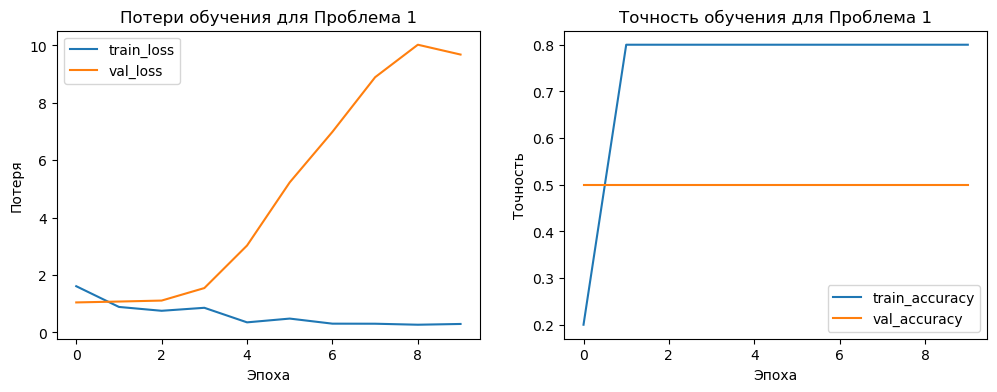

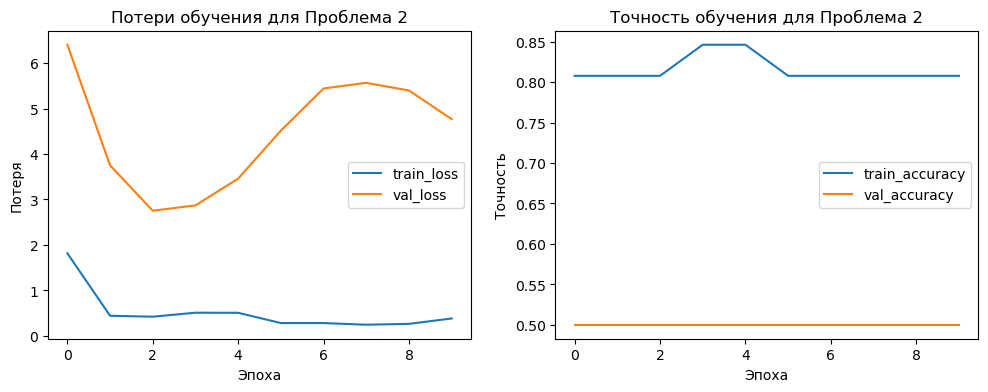

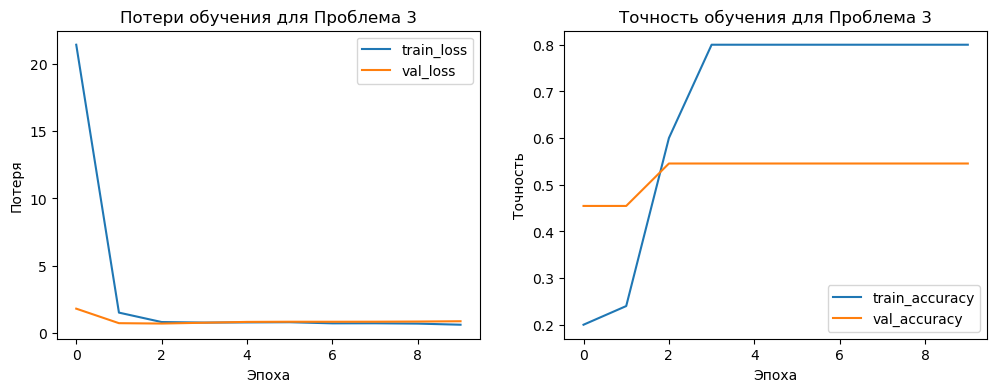

In [13]:
# графики loss и accuracy
plot_training_history(histories)

### Пробеум предсказать класс изображения

In [14]:
# функция загрузки и предобработки изображения
def load_and_preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)  # загрузка изображения
    img_array = image.img_to_array(img)  # преобразование в массив NumPy
    img_array = np.expand_dims(img_array, axis=0)  # добавление размерности для батча
    img_array /= 255.0  # нормализация значений пикселей (0-1)
    return img_array

In [15]:
# функция классификации нового изображения на основе эмбеддингов
def predict_class(class_centroids, new_image_embedding):
    new_image_embedding_flattened = new_image_embedding.flatten()  # преобразование в одномерный массив
    distances = np.linalg.norm(np.array(class_centroids) - new_image_embedding_flattened, axis=1)
    predicted_class = np.argmin(distances)  # возвращаем класс с минимальным расстоянием
    return predicted_class

In [16]:
# смотрим слои модели
for layer in model.layers:
    print(layer.name)
# имя предпоследнего солоя надо указывать в промежуточной модели!!! для получения Эмбеддингов 
# intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('dense_21').output)

input_layer
block1_conv1
block1_conv1_bn
block1_conv1_act
block1_conv2
block1_conv2_bn
block1_conv2_act
block2_sepconv1
block2_sepconv1_bn
block2_sepconv2_act
block2_sepconv2
block2_sepconv2_bn
conv2d
block2_pool
batch_normalization
add
block3_sepconv1_act
block3_sepconv1
block3_sepconv1_bn
block3_sepconv2_act
block3_sepconv2
block3_sepconv2_bn
conv2d_1
block3_pool
batch_normalization_1
add_1
block4_sepconv1_act
block4_sepconv1
block4_sepconv1_bn
block4_sepconv2_act
block4_sepconv2
block4_sepconv2_bn
conv2d_2
block4_pool
batch_normalization_2
add_2
block5_sepconv1_act
block5_sepconv1
block5_sepconv1_bn
block5_sepconv2_act
block5_sepconv2
block5_sepconv2_bn
block5_sepconv3_act
block5_sepconv3
block5_sepconv3_bn
add_3
block6_sepconv1_act
block6_sepconv1
block6_sepconv1_bn
block6_sepconv2_act
block6_sepconv2
block6_sepconv2_bn
block6_sepconv3_act
block6_sepconv3
block6_sepconv3_bn
add_4
block7_sepconv1_act
block7_sepconv1
block7_sepconv1_bn
block7_sepconv2_act
block7_sepconv2
block7_sepco

In [17]:
# cоздаем промежуточную модель для получения эмбеддингов
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('dropout_2').output)
test_embeddings = intermediate_layer_model.predict(test_generator)
test_labels = test_generator.classes
class_embeddings = {i: [] for i in range(num_classes)}


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [18]:
# сбор эмбеддингов по классам
for i in range(len(test_embeddings)):
    label = test_labels[i]
    class_embeddings[label].append(test_embeddings[i])


In [19]:
# вычисление центроидов
class_centroids = []
for i in range(num_classes):
    if class_embeddings[i]:  # проверяем что список не пустой
        centroid = np.mean(class_embeddings[i], axis=0)  # усреднение по осям
        class_centroids.append(centroid)
    else:
        class_centroids.append(np.zeros(test_embeddings.shape[1]))  # если нет эмбеддингов, добавляем нулевой вектор

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step
Предсказанный класс: greasy


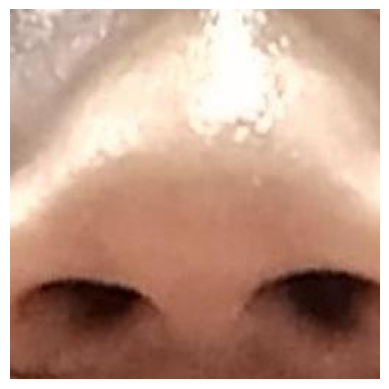

In [20]:
# смотрим изображение
img_path = 'Область носа 7/76.jpg'  
target_size = (250, 250) 
# подготовка изображения
new_image_array = load_and_preprocess_image(img_path, target_size) 
# используем промежуточную модель
new_image_embedding = intermediate_layer_model.predict(new_image_array)  
# предсказание класса
predicted_class = predict_class(class_centroids, new_image_embedding)
# вывод результата
print(f"Предсказанный класс: {class_names[predicted_class]}")

plt.imshow(new_image_array[0])  # первое изображение из массива 
plt.axis('off')  # выключаем оси 
plt.show()  

In [ ]:
# смотрим метрики classification_report про каждо1 Проблеме 1 2 3

In [21]:
# извлечение эмбеддингов и меток
def extract_embeddings_and_labels(generator):
    embeddings = []
    labels = []
    
    for _ in range(len(generator)):
        X, y = next(generator)
        emb = model.predict(X)
        # Убираем лишние размеры
        emb = np.mean(emb, axis=(1, 2))  # меняем форму эмбеддингов
        embeddings.append(emb)
        labels.append(y)

    embeddings = np.vstack(embeddings)
    labels = np.concatenate(labels)

    print('Форма эмбеддингов:', embeddings.shape)  # Ожидается (N_samples, N_features)
    print('Форма меток:', labels.shape)  # Ожидается (N_samples,)
    
    return embeddings, labels

In [22]:
# эмбеддинги и метки для тестовых данных
def prepare_data_for_problem(problem_key, generators):
    labels_map = class_mapping[problem_key]
    embeddings, labels = extract_embeddings_and_labels(generators[problem_key])
    return embeddings, labels, labels_map

# вычисляем центроиды, учитывая новую форму эмбеддингов
def compute_centroids(embeddings, labels, num_classes):
    centroids = []
    
    for i in range(num_classes):
        class_embeddings = embeddings[labels == i]
        centroid = np.mean(class_embeddings, axis=0)
        centroids.append(centroid)

    return np.array(centroids)

# оценка по расстоянию
def evaluate_distances(embeddings, centroids):
    distances = np.zeros((embeddings.shape[0], centroids.shape[0]))
    
    # расстояние от эмбеддингов до центроидов
    for i in range(centroids.shape[0]):
        distances[:, i] = np.linalg.norm(embeddings - centroids[i], axis=1)
    
    return distances


In [27]:
# функция для оценки модели classification_report
def evaluate_model(problem_name, model, generators):
    if problem_name not in generators:
        raise ValueError(f"Проблема '{problem_name}' не найдена в генераторах.")
    
    # генератор тестовых данных для выбранной проблемы
    test_generator = generators[problem_name]['test']['generator']
    num_classes = generators[problem_name]['num_classes']
    
    # извлекаем эмбеддинги и метки
    embeddings, labels = extract_embeddings_and_labels(test_generator)

    # вычисляем центроиды
    centroids = compute_centroids(embeddings, labels, num_classes)

    # оценка по расстоянию
    distances = evaluate_distances(embeddings, centroids)

    # определяем класс для каждой точки на основе минимального расстояния
    predictions = np.argmin(distances, axis=1)

    # отчет
    print("Классификация тестовых данных:")
    print(classification_report(labels, predictions, target_names=list(generators[problem_name]['train']['class_indices'].keys())))

In [28]:
# загружаем уже обученную модель
model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

problems = {
    'Проблема 1': ['clean', 'greasy'],
    'Проблема 2': ['clean', 'pigmentation'],
    'Проблема 3': ['black dots', 'clean']
}

# генераторы
generators, class_mapping = create_generators(base_dir, problems)

# оценка модели для конкретной проблемы
evaluate_model('Проблема 3', model, generators)

Found 25 images belonging to 2 classes.
Found 14 images belonging to 2 classes.
Found 26 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
Found 25 images belonging to 2 classes.
Found 11 images belonging to 2 classes.
Генераторы созданы
Проблема Проблема 1 class indices: {'clean': 0, 'greasy': 1}
Проблема Проблема 2 class indices: {'clean': 0, 'pigmentation': 2}
Проблема Проблема 3 class indices: {'black dots': 3, 'clean': 0}
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Форма эмбеддингов: (11, 2048)
Форма меток: (11,)
Классификация тестовых данных:
              precision    recall  f1-score   support

  black dots       1.00      0.67      0.80         6
       clean       0.71      1.00      0.83         5

    accuracy                           0.82        11
   macro avg       0.86      0.83      0.82        11
weighted avg       0.87      0.82      0.82        11



### В целом данная модель показывает невысокие результаты. Возможно в папки с образцами изображений я положил не совсем корректные образцы либо их недостаточно для обучения 